# Building a High-Accuracy CNN for CIFAR-10 Image Classification

## Project Overview

This notebook documents the final, optimized version of a Convolutional Neural Network (CNN) built to classify images from the CIFAR-10 dataset. The goal of this project was not just to build a model, but to go through the iterative, real-world process of diagnosing problems and systematically improving performance.

This final model achieves a **Test Accuracy of 86.39%**, a significant improvement over our initial baseline.

## The Iterative Journey

Our development process followed several key stages, with each step addressing a weakness in the previous model:

1.  **Initial Baseline Model:** We began with a simple, two-block CNN. It achieved a respectable **~60% accuracy** but showed clear signs of **overfitting**—the training loss was much lower than the validation loss, and the model struggled to generalize.

2.  **Introducing Regularization:** To combat overfitting, we first introduced **Dropout**, a technique to randomly deactivate neurons during training. We experimented with different dropout rates and found that while it helped, it wasn't a complete solution. We then added **Data Augmentation** (random flips, crops, and rotations) to the training data, forcing the model to learn more robust and generalizable features.

3.  **Scaling the Architecture:** Our regularized model was more stable but hit a performance plateau. This indicated that the model's architecture was too simple and lacked the **capacity** to learn the complex distinctions between classes (especially `cat` vs. `dog`).

4.  **The Final Model (This Notebook):** To solve the capacity issue, we implemented the deeper, more powerful architecture detailed in this notebook. The key enhancements include:
    * A deeper, VGG-style network with more convolutional layers.
    * **Batch Normalization** added after each convolutional layer to stabilize and accelerate the training of the deeper network.
    * A robust training pipeline featuring a **validation set**, **early stopping**, and **best-model checkpointing** to ensure we achieve the best possible result.

This notebook represents the culmination of that journey, showcasing a professional-grade training pipeline and a final, high-performing model.

## CONFIGURATION & ENVIRONMENT SETUP

In [1]:

import torch
import numpy as np
import random
import os

# For Reproducibility
# Ensuring our experiments are repeatable is key to good science.
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    # If you're using a GPU, this makes CUDA operations deterministic
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
set_seed(42)

# Device Selection
# Let's use a GPU if we have one, as it will speed up training significantly.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter Configuration (Our Experiment's Control Panel)
CFG = {
    "epochs": 35,          # How many times we'll loop over the entire dataset
    "batch_size": 64,      # How many images to process at once
    "num_workers": 2,      # For background data loading (use 0 on Windows/some notebooks)
    "lr": 1e-3,            # Learning Rate: how big of a step the optimizer takes
    "weight_decay": 1e-4,  # L2 Regularization strength to prevent overfitting
    "val_size": 5000       # How many images to set aside for our validation set
}

print(f"Using device: {device}")
# Create directories to save visualizations and model weights
os.makedirs("artifacts", exist_ok=True)
os.makedirs("models", exist_ok=True)

Using device: cuda



## DATA LOADING, TRANSFORMS & SPLITTING

In [2]:

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Dataset-specific Normalization
# These are the pre-calculated mean and standard deviation of the CIFAR-10 dataset.
# Using these is the correct way to normalize the data.
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

# Data Augmentation for the Training Set
# We apply random transformations to the training data to make our model more robust
# and prevent overfitting. It's like creating new, slightly different images on the fly.
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),   # Randomly crop the image
    transforms.RandomHorizontalFlip(),      # Randomly flip the image horizontally
    transforms.ToTensor(),                  # Convert image to a PyTorch Tensor
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD), # Normalize with the correct stats
])

# For the Validation & Test Sets, we only normalize
# We don't want to augment these sets, as we need a consistent evaluation.
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# Loading the Datasets
DATA_DIR = "./data"
full_train_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True,  download=True, transform=train_transform)
test_dataset       = torchvision.datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=test_transform)
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Creating a Deterministic Train/Validation Split
# This ensures our validation set is the same every time we run the notebook.
g = torch.Generator().manual_seed(42)
train_size = len(full_train_dataset) - CFG["val_size"]
train_ds, val_idx = random_split(full_train_dataset, [train_size, CFG["val_size"]], generator=g)

# To ensure our validation set isn't augmented, we create a clean copy and subset it.
clean_val_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, train=True, download=False, transform=test_transform)
val_ds = torch.utils.data.Subset(clean_val_dataset, val_idx.indices)

# Creating DataLoaders
# These helpers will batch and shuffle our data for us.
def make_loader(ds, shuffle=True):
    return DataLoader(ds, batch_size=CFG["batch_size"], shuffle=shuffle,
                      num_workers=CFG["num_workers"], pin_memory=True)

trainloader = make_loader(train_ds)
valloader   = make_loader(val_ds, shuffle=False)
testloader  = make_loader(test_dataset, shuffle=False)

print(f"Training set has {len(train_ds)} images.")
print(f"Validation set has {len(val_ds)} images.")
print(f"Test set has {len(test_dataset)} images.")

100%|██████████| 170M/170M [10:26<00:00, 272kB/s]


Training set has 45000 images.
Validation set has 5000 images.
Test set has 10000 images.


## DATA VISUALIZATION

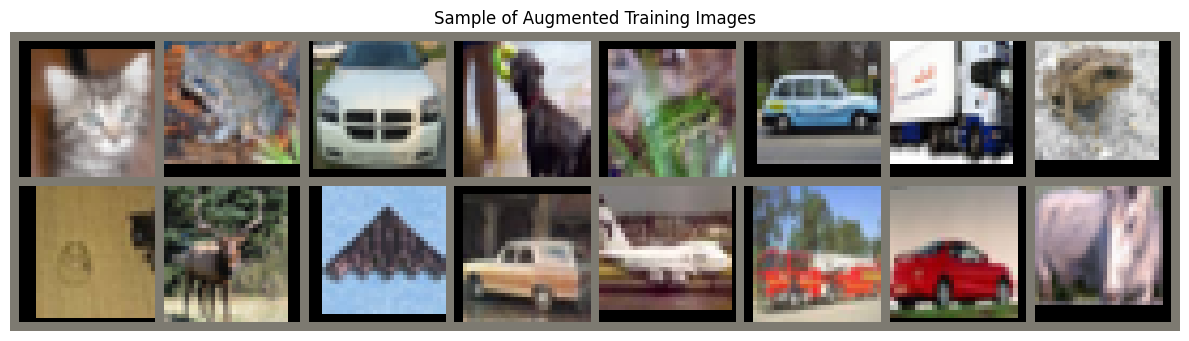

In [3]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Let's grab a single batch of images to see our augmentations in action.
xb, yb = next(iter(trainloader))

# Function to un-normalize and display an image
def unnormalize(img, mean=CIFAR10_MEAN, std=CIFAR10_STD):
    # This reverses the transforms.Normalize operation
    for channel, m, s in zip(img, mean, std):
        channel.mul_(s).add_(m)
    return img.clamp(0,1)

# Create a grid and display the images
grid = make_grid(xb[:16].cpu(), nrow=8) # Show first 16 images in 2 rows
grid = unnormalize(grid.clone())
plt.figure(figsize=(12, 4))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Sample of Augmented Training Images")
plt.tight_layout()
plt.savefig("artifacts/train_samples.png")
plt.show()

## CNN MODEL ARCHITECTURE

In [4]:

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # This architecture uses VGG-style blocks (Conv -> Conv -> Pool)
    # with Batch Normalization for stability and Dropout for regularization.
    def __init__(self):
        super().__init__()
        # Block 1
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Block 2
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Classifier Head
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        # Pass through convolutional blocks
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool2(F.relu(self.bn4(self.conv4(x))))

        # Flatten for the classifier
        x = torch.flatten(x, 1)

        # Pass through the fully-connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

net = Net().to(device)
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bi

## TRAINING PIPELINE

In [5]:

import torch.optim as optim
from time import time

# Reset Model, Optimizer, Scheduler, and History
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

history = {"train_loss": [], "val_loss": [], "val_acc": []}
best_acc, best_state, patience, patience_limit = 0.0, None, 0, 4

# Helper function for evaluation
def evaluate(model, loader):
    model.eval() # Set model to evaluation mode
    total_loss, total_acc, n = 0.0, 0.0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            bs = y.size(0)
            total_loss += loss.item() * bs
            total_acc  += (out.argmax(1) == y).float().sum().item()
            n += bs
    return total_loss / n, total_acc / n

#  The Main Training Loop
print("🚀 Starting training...")
for epoch in range(1, CFG["epochs"] + 1):
    net.train() # Set model to training mode
    t0 = time()
    run_loss, n = 0.0, 0

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = net(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        run_loss += loss.item() * y.size(0)
        n += y.size(0)

    # Calculate per-epoch stats and run validation
    train_loss = run_loss / n
    val_loss, val_acc = evaluate(net, valloader)
    scheduler.step(val_acc)

    # Log history
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.4f} val_loss={val_loss:.4f} val_acc={val_acc*100:.2f}% | time={time()-t0:.1f}s")

    # Early stopping and checkpointing
    if val_acc > best_acc:
        print(f"🎉 New best model found! Val acc: {val_acc*100:.2f}% (previously {best_acc*100:.2f}%)")
        best_acc, best_state, patience = val_acc, net.state_dict(), 0
        torch.save(best_state, "models/best_model.pth")
    else:
        patience += 1
        if patience >= patience_limit:
            print(f"⌛ Early stopping at epoch {epoch}. No improvement in {patience_limit} epochs.")
            break

print(f"\n✅ Training complete. Best validation accuracy: {best_acc*100:.2f}%")

🚀 Starting training...
Epoch 01 | train_loss=1.8230 val_loss=1.4393 val_acc=47.78% | time=19.7s
🎉 New best model found! Val acc: 47.78% (previously 0.00%)
Epoch 02 | train_loss=1.4861 val_loss=1.1875 val_acc=56.04% | time=19.0s
🎉 New best model found! Val acc: 56.04% (previously 47.78%)
Epoch 03 | train_loss=1.3197 val_loss=1.0497 val_acc=62.78% | time=17.5s
🎉 New best model found! Val acc: 62.78% (previously 56.04%)
Epoch 04 | train_loss=1.2069 val_loss=0.9195 val_acc=66.42% | time=18.5s
🎉 New best model found! Val acc: 66.42% (previously 62.78%)
Epoch 05 | train_loss=1.1349 val_loss=0.8990 val_acc=68.16% | time=17.6s
🎉 New best model found! Val acc: 68.16% (previously 66.42%)
Epoch 06 | train_loss=1.0737 val_loss=0.8238 val_acc=70.64% | time=17.7s
🎉 New best model found! Val acc: 70.64% (previously 68.16%)
Epoch 07 | train_loss=1.0176 val_loss=0.8196 val_acc=71.20% | time=18.3s
🎉 New best model found! Val acc: 71.20% (previously 70.64%)
Epoch 08 | train_loss=0.9843 val_loss=0.8216 va

## VISUALIZE TRAINING RESULTS

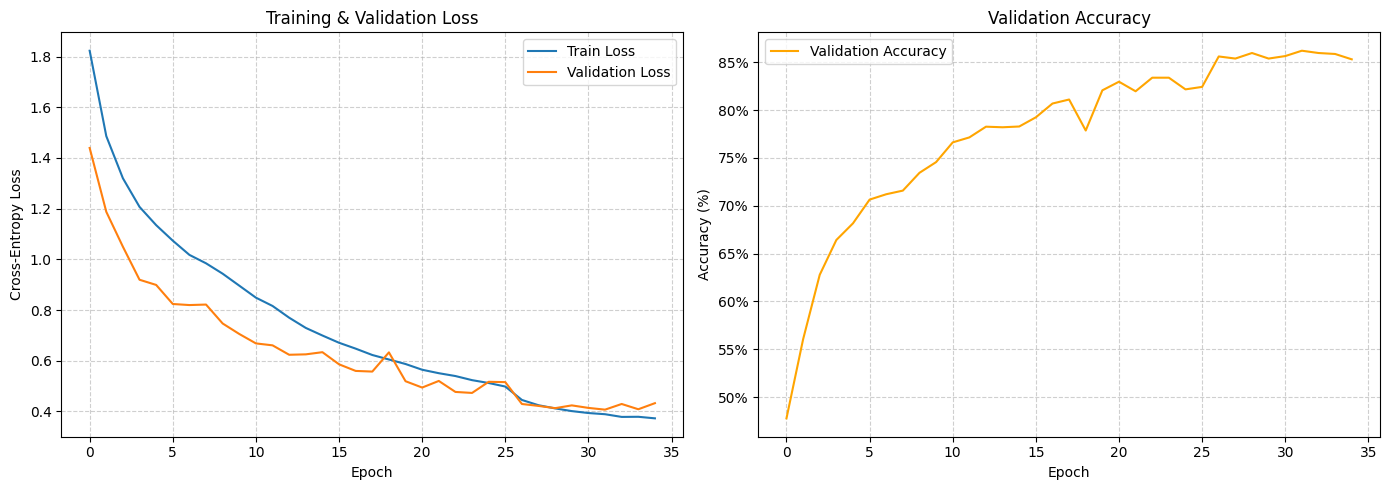

In [6]:

import pandas as pd

# Plotting the training and validation loss/accuracy
history_df = pd.DataFrame(history)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(history_df["train_loss"], label="Train Loss")
axes[0].plot(history_df["val_loss"], label="Validation Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Cross-Entropy Loss")
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot Accuracy
axes[1].plot(history_df["val_acc"], label="Validation Accuracy", color='orange')
axes[1].set_title("Validation Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y*100)))
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("artifacts/training_history.png")
plt.show()

## FINAL EVALUATION ON TEST SET

Best model weights loaded for final evaluation.

Final Test Accuracy: 86.39%
Final Test Loss: 0.4255

Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.86      0.87      1000
  automobile       0.95      0.94      0.94      1000
        bird       0.84      0.77      0.81      1000
         cat       0.80      0.68      0.74      1000
        deer       0.87      0.84      0.85      1000
         dog       0.79      0.81      0.80      1000
        frog       0.83      0.94      0.88      1000
       horse       0.87      0.91      0.89      1000
        ship       0.91      0.93      0.92      1000
       truck       0.88      0.95      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



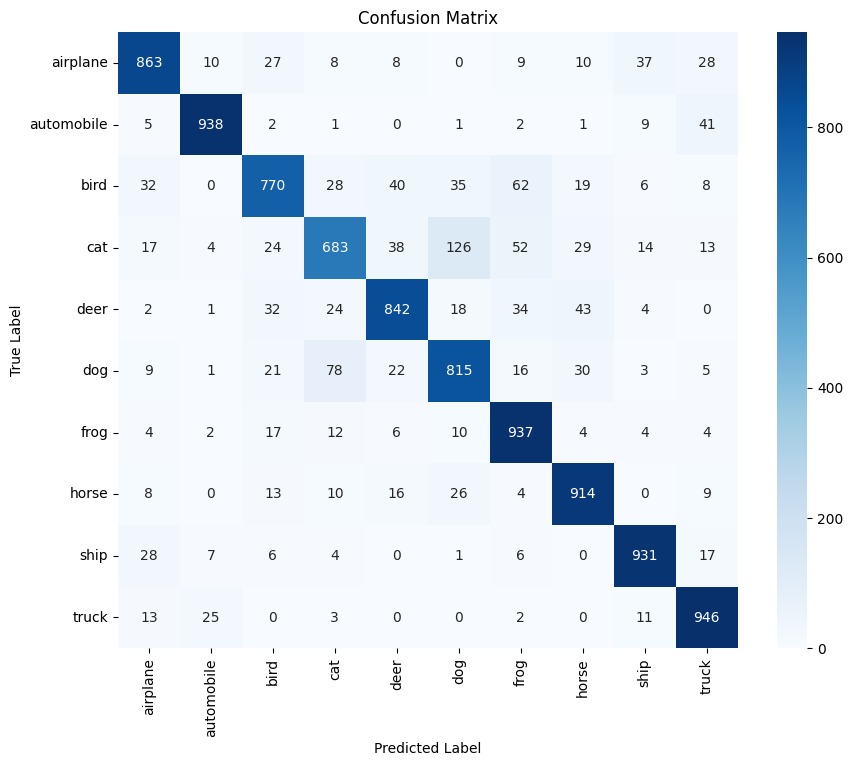

In [7]:

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- Load the best model weights ---
net.load_state_dict(torch.load("models/best_model.pth"))
print("Best model weights loaded for final evaluation.")

# Get test loss and accuracy
test_loss, test_acc = evaluate(net, testloader)
print(f"\nFinal Test Accuracy: {test_acc*100:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

# Generate Classification Report and Confusion Matrix
y_true, y_pred = [], []
net.eval()
with torch.no_grad():
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        out = net(x)
        y_pred.extend(out.argmax(1).cpu().numpy())
        y_true.extend(y.cpu().numpy())

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.savefig("artifacts/confusion_matrix.png")
plt.show()

## Results & Conclusion

This project successfully demonstrates a complete, iterative workflow for building a high-performing image classifier. By systematically applying modern deep learning techniques, we significantly improved upon our initial baseline model.

### Final Performance
* **Best Validation Accuracy:** **86.20%**
* **Final Test Accuracy:** **86.39%**

This represents a **+26% absolute improvement** over our initial simple model, showcasing the effectiveness of the final architecture and training strategy.

### Key Insights from the Results:

* **Effective Regularization:** The combination of **Data Augmentation**, **Dropout**, and **Batch Normalization** proved critical. The final training and validation loss curves show a healthy, stable learning process without significant overfitting.
* **Hierarchical Features Matter:** The deeper, VGG-style architecture was able to learn the complex features necessary to distinguish between visually similar classes. This is most evident in the performance on animal classes:
    * **Cat Accuracy:** Improved from a baseline of ~30% to **68% recall**.
    * **Bird Accuracy:** Improved from ~40% to **77% recall**.
* **High-Confidence Classes:** The model is exceptionally confident and accurate at identifying distinct objects like **automobiles (94% recall)** and **ships (93% recall)**, as shown in the confusion matrix.
* **Remaining Challenges:** The primary source of error remains the confusion between `cat` and `dog`, which is a well-known challenge for the CIFAR-10 dataset and highlights an area for future architectural improvements.

Overall, the project successfully implements a professional-grade training pipeline, resulting in a robust and accurate CNN classifier.